In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
# from sklearn.tree import export_graphviz
# import graphviz
# import os
# os.environ["PATH"] += os.pathsep + 'C:/Users/danie/anaconda3/Library/bin/graphviz'
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

In [2]:
data = pd.read_excel('data/data.xlsx')

In [3]:
data.head()

,program,men students,women students,men professors,women professors,professors/doctorate,professors/masters,professors/bachelors,titular professors,associate professors,professor assistants,plant professors,instructor professors,emeritus professors,visitant professors
0,Administración,707,495,105,50,55,10,0,4.0,25.5,27.0,0,1,1,0.5
1,Arquitectura,334,388,58,30,10,16,1,2.5,14.5,9.0,0,0,0,0.0
2,Diseño,191,642,40,41,7,23,1,0.0,17.5,13.0,0,0,0,0.0
3,Arquitectura y Diseño,525,103,99,71,17,40,2,3.5,32.0,22.0,0,0,0,0.0
4,Arte,57,147,27,24,0,17,0,1.0,11.0,5.0,0,0,0,0.0


## Decision Trees

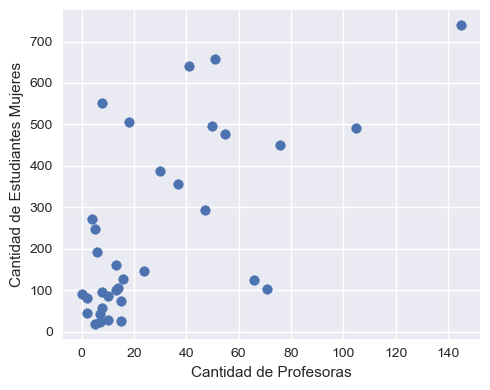

In [12]:
plt.style.use('seaborn')

plt.figure(figsize = (5, 4), dpi = 100)
plt.scatter(data['women professors'], data['women students'])
_ = plt.xlabel('Cantidad de Profesoras')
_ = plt.ylabel('Cantidad de Estudiantes Mujeres')
plt.tight_layout()
plt.savefig('results/decision_trees/data.png')

In [18]:
X = data[['women professors']]
y = data['women students']

dtr1 = DecisionTreeRegressor(max_depth = 2, random_state = 1)

_ = dtr1.fit(X, y)

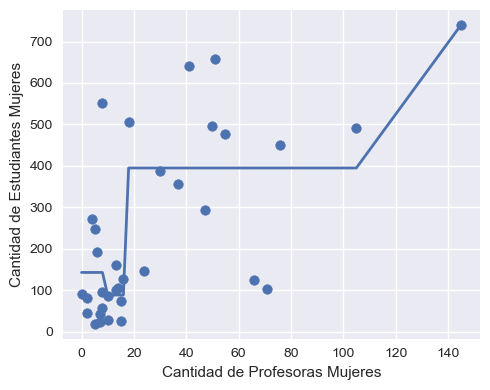

In [19]:
plt.style.use('seaborn')

plt.figure(figsize = (5, 4), dpi = 100)
plt.scatter(data['women professors'], data['women students'], label = 'Datos')
plt.plot(data['women professors'].sort_values(),
         dtr1.predict(data['women professors'].sort_values().to_frame()),
         label = 'Modelo', linewidth = 2)
_ = plt.xlabel('Cantidad de Profesoras Mujeres')
_ = plt.ylabel('Cantidad de Estudiantes Mujeres')
plt.tight_layout()
plt.savefig('results/decision_trees/initial_model.png')

In [10]:
dot_data = export_graphviz(dtr1, feature_names=['women professors'],  
                           filled=True, rounded=True)  

graph = graphviz.Source(dot_data)
_ = graph.render('results/decision_trees/initial_tree')

NameError: name 'export_graphviz' is not defined

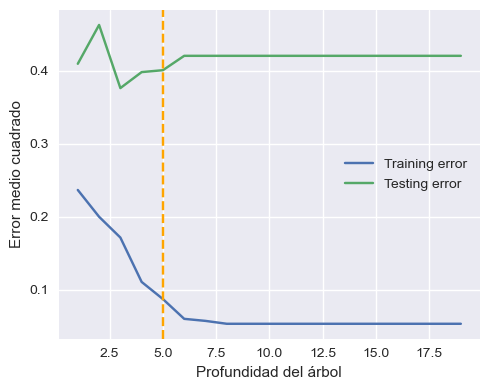

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = True)

max_depths = range(1, 20)
training_error = []
for max_depth in max_depths:
    model_1 = DecisionTreeRegressor(max_depth = max_depth)
    model_1.fit(X, y)
    training_error.append(mse(y, model_1.predict(X))/100000)
    
testing_error = []
for max_depth in max_depths:
    model_2 = DecisionTreeRegressor(max_depth = max_depth)
    model_2.fit(X_train, y_train)
    testing_error.append(mse(y_test, model_2.predict(X_test))/100000)

plt.figure(figsize = (5, 4), dpi = 100)
plt.plot(max_depths, training_error, label = 'Training error')
plt.plot(max_depths, testing_error, label = 'Testing error')
plt.axvline(x = 5, color='orange', linestyle='--')
plt.xlabel('Profundidad del árbol')
plt.ylabel('Error medio cuadrado')
plt.legend()
plt.tight_layout()
plt.savefig('results/decision_trees/error.png')

In [21]:
model = DecisionTreeRegressor()

gs = GridSearchCV(model,
                  param_grid = {'max_depth': range(1, 20),
                                'min_samples_split': range(10, 60, 10)},
                  cv = 5,
                  n_jobs = 10,
                  scoring='neg_mean_squared_error')

gs.fit(X_train, y_train)

print(gs.best_params_)
print(-gs.best_score_)

{'max_depth': 1, 'min_samples_split': 10}
22735.418856348606


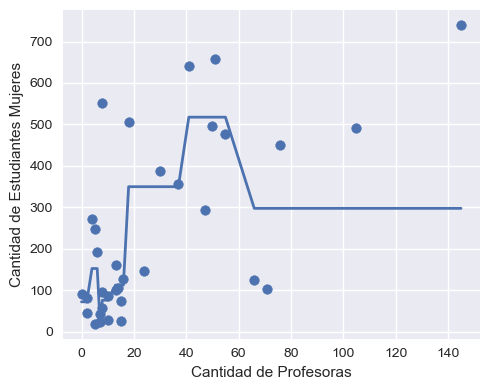

In [22]:
plt.style.use('seaborn')

plt.figure(figsize = (5, 4), dpi = 100)
plt.scatter(data['women professors'], data['women students'], label = 'Datos')
new_model = DecisionTreeRegressor(max_depth = 5,
                                  min_samples_split = 5)
new_model.fit(X_train, y_train)

plt.plot(data['women professors'].sort_values(),
         new_model.predict(data['women professors'].sort_values().to_frame()),
         label = 'Modelo', linewidth = 2)
_ = plt.xlabel('Cantidad de Profesoras')
_ = plt.ylabel('Cantidad de Estudiantes Mujeres')
plt.tight_layout()
plt.savefig('results/decision_trees/best_model.png')

## Random Forests

In [48]:
predictors = list(data.keys())
predictors.remove('program')
predictors.remove('women students')
print(predictors, np.shape(np.array(predictors)))

['men students', 'men professors', 'women professors', 'professors/doctorate', 'professors/masters', 'professors/bachelors', 'titular professors', 'associate professors', 'professor assistants', 'plant professors', 'instructor professors', 'emeritus professors', 'visitant professors'] (13,)


In [49]:
import sklearn.model_selection

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
                                    data[predictors], data['women students'], test_size = 0.5)

In [50]:
import sklearn.ensemble

rf = sklearn.ensemble.RandomForestRegressor(n_estimators = 10)
rf.fit(X_train, y_train)
_ = rf.estimators_

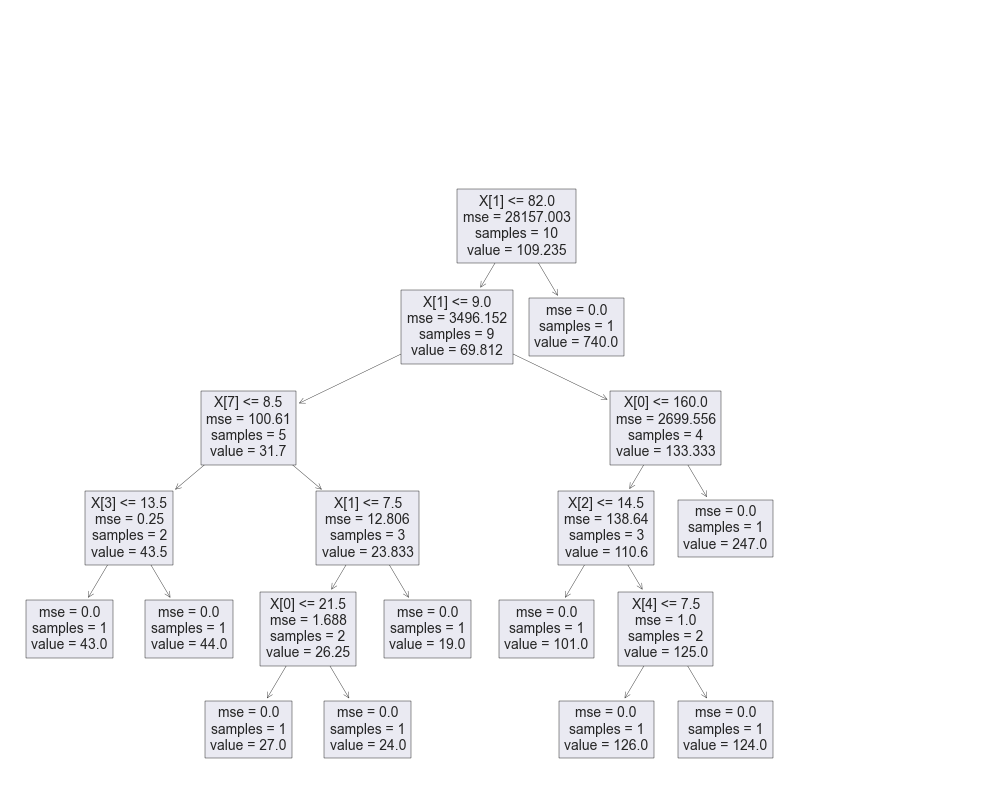

In [53]:
plt.figure(figsize=(10, 8), dpi = 100)
_= sklearn.tree.plot_tree(rf.estimators_[5])
plt.tight_layout()
plt.savefig('results/random_forests/tree.png')

In [54]:
rf.predict(X_test)

array([498.5, 247.6,  39.3, 229.6, 209.2, 126.7, 127.6, 164. , 354.9,
       190.4, 142.9, 151.8, 159. , 397.7, 149.2, 545.2, 415.6])

In [249]:
n_trees = np.arange(1, 20, 1)
mse_train = []
mse_test = []
feature_importance = np.zeros((len(n_trees), len(predictors)))

for i, n_tree in enumerate(n_trees):
    clf = sklearn.ensemble.RandomForestRegressor(n_estimators = n_tree, max_features = 'sqrt')
    clf.fit(X_train, y_train)
    mse_train.append(mse(y_train, clf.predict(X_train))/100000)
    mse_test.append(mse(y_test, clf.predict(X_test))/100000)
    feature_importance[i, :] = clf.feature_importances_

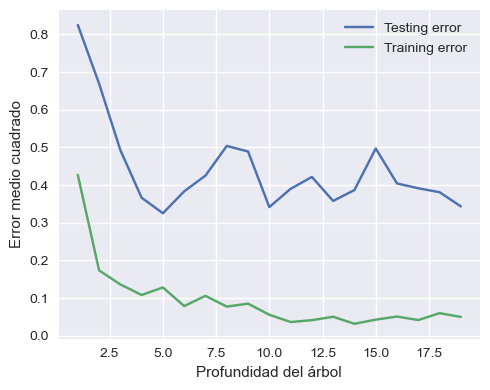

In [250]:
plt.style.use('seaborn')

plt.figure(figsize = (5, 4), dpi = 100)
plt.plot(n_trees, mse_test, label = 'Testing error')
plt.plot(n_trees, mse_train, label = 'Training error')
plt.xlabel('Profundidad del árbol')
plt.ylabel('Error medio cuadrado')
# plt.axvline(x = 5, color='orange', linestyle='--')
_ = plt.legend()
plt.tight_layout()
plt.savefig('results/random_forests/error.png')

men students             0.132948
men professors           0.116183
women professors         0.168497
professors/doctorate     0.129184
professors/masters       0.081003
professors/bachelors     0.039378
titular professors       0.056375
associate professors     0.115335
professor assistants     0.088444
plant professors         0.022206
instructor professors    0.021202
emeritus professors      0.013317
visitant professors      0.015928
dtype: float64


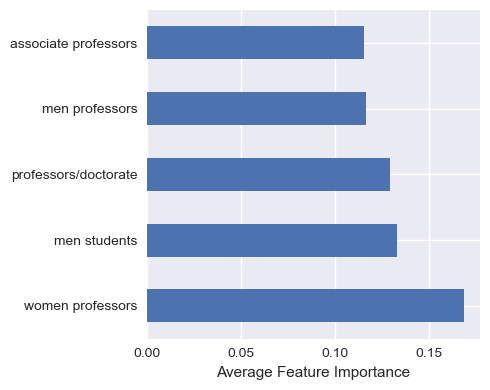

In [251]:
avg_importance = np.average(feature_importance, axis = 0)
a = pd.Series(avg_importance, index  = predictors)
print(a)
plt.figure(figsize = (5, 4), dpi = 100)
a.nlargest().plot(kind = 'barh')
plt.xlabel('Average Feature Importance')
plt.tight_layout()
plt.savefig('results/random_forests/importances.png')